## Wrapper Methods

The data was obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition). Categorical variables were changed to numerical ones in order to facilitate analysis.

First, you'll fit a logistic regression model to try to predict whether survey respondents are obese based on their answers to questions in the survey. After that, you'll use three different wrapper methods to choose a smaller feature subset.

You'll use sequential forward selection, sequential backward floating selection, and recursive feature elimination. After implementing each wrapper method, you'll evaluate the model accuracy on the resulting smaller feature subsets and compare that with the model accuracy using all available features.

In [9]:
pip install mlxtend

                                              0.0/1.4 MB ? eta -:--:--
     --------                                 0.3/1.4 MB 6.5 MB/s eta 0:00:01
     --------------------                     0.8/1.4 MB 8.0 MB/s eta 0:00:01
     ----------------------------------       1.3/1.4 MB 8.0 MB/s eta 0:00:01
     ---------------------------------------- 1.4/1.4 MB 8.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: C:\Users\ivanx\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [247]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

## Evaluating a Logistic Regression Model

The data set `obesity` contains 18 predictor variables. Here's a brief description of them.

* `Gender` is `1` if a respondent is male and `0` if a respondent is female.
* `Age` is a respondent's age in years.
* `family_history_with_overweight` is `1` if a respondent has family member who is or was overweight, `0` if not.
* `FAVC` is `1` if a respondent eats high caloric food frequently, `0` if not.
* `FCVC` is `1` if a respondent usually eats vegetables in their meals, `0` if not.
* `NCP` represents how many main meals a respondent has daily (`0` for 1-2 meals, `1` for 3 meals, and `2` for more than 3 meals).
* `CAEC` represents how much food a respondent eats between meals on a scale of `0` to `3`.
* `SMOKE` is `1` if a respondent smokes, `0` if not.
* `CH2O` represents how much water a respondent drinks on a scale of `0` to `2`.
* `SCC` is `1` if a respondent monitors their caloric intake, `0` if not.
* `FAF` represents how much physical activity a respondent does on a scale of `0` to `3`.
* `TUE` represents how much time a respondent spends looking at devices with screens on a scale of `0` to `2`.
* `CALC` represents how often a respondent drinks alcohol on a scale of `0` to `3`.
* `Automobile`, `Bike`, `Motorbike`, `Public_Transportation`, and `Walking` indicate a respondent's primary mode of transportation. Their primary mode of transportation is indicated by a `1` and the other columns will contain a `0`.

The outcome variable, `NObeyesdad`, is a `1` if a patient is obese and a `0` if not.

Use the `.head()` method and inspect the data.

In [248]:
# Load and Convert data 
obesity = pd.read_csv("obesity.csv")
obesity['Gender'] = obesity['Gender'].replace({'Male':1,'Female':0})
obesity['family_history_with_overweight'] = obesity['family_history_with_overweight'].replace({'yes':1,'no':0})
obesity['FAVC'] = obesity['FAVC'].replace({'yes':1,'no':0})
obesity['CAEC'] = obesity['CAEC'].replace({'no':0,'Sometimes':1,'Frequently':2,'Always':3})
obesity['SMOKE'] = obesity['SMOKE'].replace({'yes':1,'no':0})
obesity['SCC'] = obesity['SCC'].replace({'yes':1,'no':0})
obesity['CALC'] = obesity['CAEC'].replace({'no':0,'Sometimes':1,'Frequently':2,'Always':3})

obesity.is_copy = None

obesity['Automobile'] = 0
obesity['Bike'] = 0
obesity['Motorbike'] = 0
obesity['Public_Transportation'] = 0
obesity['Walking'] = 0

pd.options.mode.chained_assignment = None

for i in range(len(obesity)):
    if obesity['MTRANS'].iloc[i] == "Public_Transportation":
        obesity['Public_Transportation'].iloc[i] = 1
    elif obesity['MTRANS'].iloc[i] == "Walking":
        obesity['Walking'].iloc[i] = 1
    elif obesity['MTRANS'].iloc[i] == "Automobile":
        obesity['Automobile'].iloc[i] = 1
    elif obesity['MTRANS'].iloc[i] == "Motorbike":
        obesity['Motorbike'].iloc[i] = 1
    elif obesity['MTRANS'].iloc[i] == "Bike":
        obesity['Bike'].iloc[i] = 1
    
obesity = obesity.drop(columns=['MTRANS'])


obesity['NObeyesdad'] = obesity['NObeyesdad'].replace({'Insufficient_Weight':0, 'Normal_Weight':0,'Overweight_Level_I':0,'Overweight_Level_II':0, 'Obesity_Type_I':1, 'Obesity_Type_II':1, 'Obesity_Type_III':1, })

# Inspect the data
obesity.head(13)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,NObeyesdad,Automobile,Bike,Motorbike,Public_Transportation,Walking
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,...,0,0.0,1.0,1,0,0,0,0,1,0
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,...,1,3.0,0.0,1,0,0,0,0,1,0
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,...,0,2.0,1.0,1,0,0,0,0,1,0
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,...,0,2.0,0.0,1,0,0,0,0,0,1
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,...,0,0.0,0.0,1,0,0,0,0,1,0
5,1,29.0,1.62,53.0,0,1,2.0,3.0,1,0,...,0,0.0,0.0,1,0,1,0,0,0,0
6,0,23.0,1.50,55.0,1,1,3.0,3.0,1,0,...,0,1.0,0.0,1,0,0,0,1,0,0
7,1,22.0,1.64,53.0,0,0,2.0,3.0,1,0,...,0,3.0,0.0,1,0,0,0,0,1,0
8,1,24.0,1.78,64.0,1,1,3.0,3.0,1,0,...,0,1.0,1.0,1,0,0,0,0,1,0
9,1,22.0,1.72,68.0,1,1,2.0,3.0,1,0,...,0,1.0,1.0,1,0,0,0,0,1,0


In [249]:
# Check unique values

# Predictors
print(obesity['Gender'].unique())
print(obesity['family_history_with_overweight'].unique())
print(obesity['FAVC'].unique())
#print(obesity['FCVC'].unique())
#print(obesity['NCP'].unique())
print(obesity['CAEC'].unique())
print(obesity['SMOKE'].unique())
#print(obesity['CH2O'].unique())
print(obesity['SCC'].unique())
#print(obesity['FAF'].unique())
#print(obesity['TUE'].unique())
print(obesity['CALC'].unique())
#print(obesity['MTRANS'].unique())
print(obesity['Automobile'].unique())
#print(obesity['Bike'].unique())
#print(obesity['Motorbike'].unique())
#print(obesity['Public_Transportation'].unique())
#print(obesity['Walking'].unique())

# Target
print(obesity['NObeyesdad'].unique())

[0 1]
[1 0]
[0 1]
[1 2 3 0]
[0 1]
[0 1]
[1 2 3 0]
[0 1]
[0 1]


### Split the data into `X` and `y`

In order to use a linear regression model, you'll need to split the data into two parts: the predictor variables and an outcome variable. Do this by splitting the data into a DataFrame of predictor variables called `X` and a Series of outcome variables `y`.

In [250]:
# Split the data into predictor variables and an outcome variable
X = obesity.drop(["NObeyesdad"], axis=1)
y = obesity.NObeyesdad

### Logistic regression model

Create a logistic regression model called `lr`. Include the parameter `max_iter=1000` to make sure that the model will converge when you try to fit it.

In [251]:
# Create a logistic regression model
lr = LogisticRegression(max_iter=1000)

### Fit the model

Use the `.fit()` method on `lr` to fit the model to `X` and `y`.

In [252]:
# Fit the logistic regression model
lr.fit(X, y)

LogisticRegression(max_iter=1000)

### Model accuracy

A model's _accuracy_ is the proportion of classes that the model correctly predicts. is Compute and print the accuracy of `lr` by using the `.score()` method. What percentage of respondents did the model correctly predict as being either obese or not obese? You may want to write this number down somewhere so that you can refer to it during future tasks.

In [253]:
# Print the accuracy of the model
print(lr.score(X,y))

0.9720511605873994


## Sequential Forward Selection

Now that you've created a logistic regression model and evaluated its performance, you're ready to do some feature selection. 

Create a sequential forward selection model called `sfs`. 
* Be sure to set the `estimator` parameter to `lr` and set the `forward` and `floating` parameters to the appropriate values. 
* Also use the parameters `k_features=9`, `scoring='accuracy'`, and `cv=0`.

In [254]:
# Create a sequential forward selection model
sfs = SFS(lr, 
          k_features=9, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=0)

### Fit the model

Use the `.fit()` method on `sfs` to fit the model to `X` and `y`. This step will take some time (not more than a minute) to run.

In [255]:
# Fit the sequential forward selection model to X and y
sfs.fit(X, y)

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          k_features=(9, 9), scoring='accuracy')

### Inspect the results

Now that you've run the sequential forward selection algorithm on the logistic regression model with `X` and `y` you can see what features were chosen and check the model accuracy on the smaller feature set. Print `sfs.subsets_[9]` to inspect the results of sequential forward selection.

In [256]:
# Inspect the results of sequential forward selection
print(sfs.subsets_[9])

{'feature_idx': (0, 1, 2, 3, 4, 6, 8, 13, 15), 'cv_scores': array([0.97347229]), 'avg_score': 0.9734722880151587, 'feature_names': ('Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FCVC', 'CAEC', 'TUE', 'Automobile')}


### Chosen features and model accuracy

Use the dictionary `sfs.subsets_[9]` to print a tuple of chosen feature names. Then use it to print the accuracy of the model after doing sequential forward selection. How does this compare to the model's accuracy on all available features?

In [257]:
# See which features sequential forward selection chose
print(sfs.subsets_[9]['feature_names'])

# Print the model accuracy after doing sequential forward selection
print(sfs.subsets_[9]['avg_score'])

('Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FCVC', 'CAEC', 'TUE', 'Automobile')
0.9734722880151587


### Visualize model accuracy

It can be helpful to visualize the results of sequential forward selection and see how accuracy is affected as each feature is added. Use the code `plot_sfs(sfs.get_metric_dict())` to plot the model accuracy as a function of the number of features used. Make sure to show your plot as well.

C:\Users\ivanx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ivanx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


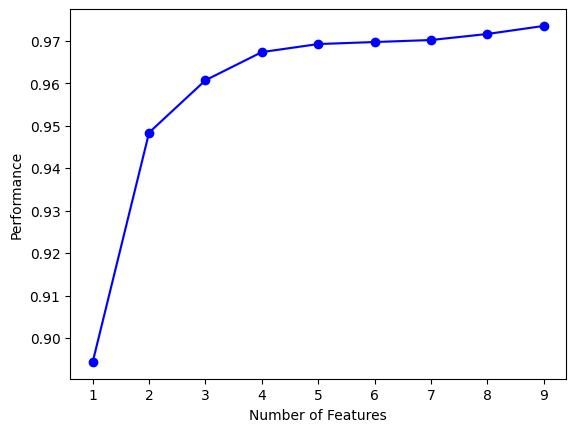

In [258]:
# Plot the model accuracy as a function of the number of features used
plot_sfs(sfs.get_metric_dict())
plt.show()

## Sequential Backward Selection

Sequential forward selection was able to find a feature subset that performed marginally better than the full feature set. Let's use a different sequential method and see how it compares.

Create a sequential backward selection model called `sbs`. 
* Be sure to set the `estimator` parameter to `lr` and set the `forward` and `floating` parameters to the appropriate values.
* Also use the parameters `k_features=7`, `scoring='accuracy'`, and `cv=0`.

In [259]:
# Create a sequential backward selection model
sbs = SFS(lr, 
          k_features=7, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=0)

### Fit the model

Use the `.fit()` method on `sbs` to fit the model to `X` and `y`.

In [260]:
# Fit the sequential backward selection model to X and y
sbs.fit(X, y)

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          forward=False, k_features=(7, 7), scoring='accuracy')

### Inspect the results

Now that you've run the sequential backward selection algorithm on the logistic regression model with `X` and `y` you can see what features were chosen and check the model accuracy on the smaller feature set. Print `sbs.subsets_[7]` to inspect the results of sequential backward selection.

In [261]:
# Inspect the results of sequential backward selection
print(sbs.subsets_[7])

{'feature_idx': (0, 1, 2, 3, 4, 13, 15), 'cv_scores': array([0.97299858]), 'avg_score': 0.9729985788725722, 'feature_names': ('Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'TUE', 'Automobile')}


### Chosen features and model accuracy

Use the dictionary `sbs.subsets_[7]` to print a tuple of chosen feature names. Then use it to print the accuracy of the model after doing sequential backward selection. How does this compare to the model's accuracy on all available features?

In [262]:
# See which features sequential backward selection chose
print(sbs.subsets_[7]['feature_names'])

# Print the model accuracy after doing sequential backward selection
print(sbs.subsets_[7]['avg_score'])

('Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'TUE', 'Automobile')
0.9729985788725722


### Visualize model accuracy

You can visualize the results of sequential backward floating selection just as you did with sequential forward selection. Use the code `plot_sfs(sbs.get_metric_dict())` to plot the model accuracy as a function of the number of features used.

C:\Users\ivanx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ivanx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


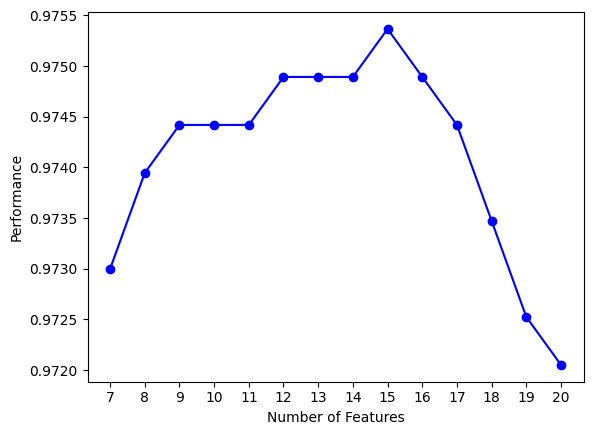

In [263]:
# Plot the model accuracy as a function of the number of features used
plot_sfs(sbs.get_metric_dict())
plt.show()

## Recursive Feature Elimination

So far you've tried two different sequential feature selection methods. Let's try one more: recursive feature elimination. First you'll standardize the data, then you'll fit the RFE model and inspect the results.

At a later step of this project, you'll need to be able to access feature names. Enter the code `features = X.columns` for use later.

In [264]:
# Get feature names
features = X.columns
print(features)

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'Automobile', 'Bike', 'Motorbike', 'Public_Transportation',
       'Walking'],
      dtype='object')


### Standardize the data

Before doing applying recursive feature elimination it is necessary to standardize the data. Standardize `X` and save it as a DataFrame by creating a `StandardScaler()` object and using the `.fit_transform()` method.

In [265]:
# Standardize the data
X = pd.DataFrame(StandardScaler().fit_transform(X))

### Recursive feature elimination model

Create an `RFE()` object that selects `8` features. Be sure to set the `estimator` parameter to `lr`.

In [266]:
# Create a recursive feature elimination model
rfe = RFE(estimator=lr, n_features_to_select=6)

### Fit the model

Fit the recursive feature elimination model to `X` and `y`.

In [267]:
# Fit the recursive feature elimination model to X and y
rfe.fit(X, y)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=6)

### Inspect chosen features

Now that you've fit the RFE model you can evaluate the results. Create a list of chosen feature names and call it `rfe_features`. You can use a list comprehension and filter the features in `zip(features, rfe.support_)` based on whether their support is `True` (meaning the model kept them) or `False` (meaning the model eliminated them).

Hint: `[f for (f, support) in zip(features, rfe.support_) if support]` will produce the desired list of feature names.

In [268]:
# See which features recursive feature elimination chose
rfe_features = [f for (f, support) in zip(features, rfe.support_) if support]
print(rfe_features)

['Gender', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'SCC']


### Model accuracy

Use the `.score()` method on `rfe` and print the model accuracy after doing recursive feature elimination. How does this compare to the model's accuracy on all available features?

In [269]:
# Print the model accuracy after doing recursive feature elimination
print(rfe.score(X, y))

0.9966840360018948


### Predict

Use `.predict()` method to predict something using the created models.

In [279]:
labels = obesity.iloc[0].keys()
print(labels)
fake_slim_person =  [0, 30, 1.85, 54, 0, 0, 2, 3, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 0]
fake_fat_person =  [1, 40, 1.52, 104, 1, 0, 1, 2, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]


fake_slim_2Darray = np.array(fake_slim_person)
fake_slim_2Darray = fake_slim_2Darray.reshape(1, -1)

fake_fat_2Darray = np.array(fake_fat_person)
fake_fat_2Darray = fake_fat_2Darray.reshape(1, -1)


print(fake_slim_2Darray)
print(fake_fat_2Darray)

# rfe - Overfitted
print(rfe.predict(fake_slim_2Darray))
print(rfe.predict(fake_fat_2Darray))
print(rfe.predict_proba(fake_slim_2Darray))
print(rfe.predict_proba(fake_fat_2Darray))

# lr
print(lr.predict(fake_slim_2Darray))
print(lr.predict(fake_fat_2Darray))
print(lr.predict_proba(fake_slim_2Darray))
print(lr.predict_proba(fake_fat_2Darray))

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'NObeyesdad', 'Automobile', 'Bike', 'Motorbike',
       'Public_Transportation', 'Walking'],
      dtype='object')
[[ 0.   30.    1.85 54.    0.    0.    2.    3.    1.    0.    2.    0.
   0.    1.    1.    0.    0.    0.    1.    0.  ]]
[[  1.    40.     1.52 104.     1.     0.     1.     2.     0.     1.
    1.     1.     1.     0.     0.     1.     1.     1.     0.     1.  ]]
[1]
[1]
[[0. 1.]]
[[0. 1.]]
[0]
[1]
[[9.99993990e-01 6.00996245e-06]]
[[7.21096265e-04 9.99278904e-01]]


C:\Users\ivanx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\ivanx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\ivanx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\ivanx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: 